<a href="https://colab.research.google.com/github/NiccoloSalvi/naml/blob/main/Convolution1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D convolutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import linalg
import time

Consider the square wave discrete signal:

$$ \mathbf{v}_i=
\begin{cases}
0, & i = 1,\dots, 50 \\
1, & i = 51,\dots, 75 \\
0, & i = 76,\dots, 100 \\
\end{cases}
$$

Define the vector $\mathbf{v}$ and plot the corresponding signal.

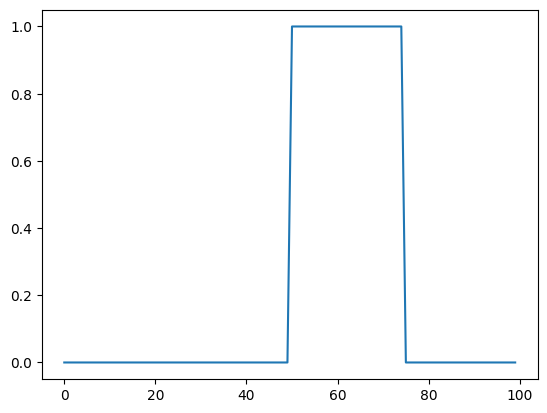

In [2]:
v = np.zeros(100)
v[50 : 75] = 1

plt.plot(v)

Consider the following kernels $\mathbf{k}$:

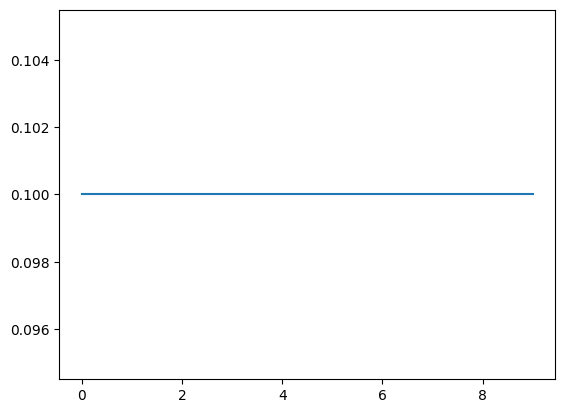

In [3]:
### first kernel --> moving kernel average
k = np.ones(10) / 10

### second kernel --> gaussian kernel
#k = signal.gaussian(20, std=3)
#k = k / np.sum(k)

### third kernel --> finite difference kernel
#k = np.array([-1, 2, -1])

plt.plot(k)

In what follows, we will compute the convolution between $\mathbf{v}$ and $\mathbf{k}$ in 4 different manners. At the end of each point, plot the obtained filtered (i.e. convolved) signal.

## 1. Toeplitz matrix

Here's a recap that merges the most important information from the previous explanations about using **Toeplitz matrices for convolution** and the **relation to FFT-based convolution**:

### **1. Using Toeplitz Matrices for Convolution**

A **Toeplitz matrix** can be used to perform convolution by converting the **kernel** into a structured matrix, where each row represents a **shifted version** of the kernel. This effectively mimics the sliding operation of the kernel over the signal when you perform matrix multiplication.

#### **Constructing the Toeplitz Matrix:**
- **Kernel Preparation:** Create a **zero-padded version** of the kernel as the **first column** of the Toeplitz matrix. This allows the kernel to slide over the entire signal, including the edges.
- **Matrix Size:** If your signal `v` has **100 elements** and your kernel `k` has **10 elements**, the resulting Toeplitz matrix should be **(109 x 100)**. This ensures that the kernel can move across all parts of the signal, including when it extends beyond the edges. The output length will be **109**.

#### **Why Use Padding in Convolution?**
- **Preserves Edge Information:** Zero-padding allows the kernel to slide over the **start** and **end** of the signal, ensuring that no information is lost at the edges.
- **Smoothing:** Padding helps apply smoothing effects uniformly across the signal, including the boundaries, which might otherwise be cut off in a **valid convolution**.
- **Consistent Behavior:** The result is a **full convolution**, where the output length is **$N + M - 1$**, accommodating all shifts of the kernel.

### **2. Relation to FFT-Based Convolution**

The **Fast Fourier Transform (FFT)** offers an efficient way to compute convolutions, based on a key mathematical property:
$$
\text{Convolution}(x * k) \equiv \text{IFFT}(\text{FFT}(x) \cdot \text{FFT}(k))
$$
- **Efficiency:** FFT-based convolution is typically faster than direct convolution (or Toeplitz-based convolution) for **large signals**, reducing the computational complexity from $O(N^2)$ to $O(N \log N)$.
- **Padding in FFT:** Just like the Toeplitz approach, **FFT-based convolution** involves padding the signal and kernel, ensuring the output length matches **$N + M - 1$**.

### **3. Why Not Use a (100 x 100) Toeplitz Matrix?**
- A **(100 x 100)** Toeplitz matrix would perform a **valid convolution**, meaning the kernel could only be applied within the bounds of the signal, producing a **shorter output** (e.g., **91 elements**).
- **Valid convolution** excludes the edges, leading to a loss of information at the boundaries, which is often undesirable in practical scenarios.

### **4. Key Takeaways:**
1. **Constructing Toeplitz for Convolution:**
   - Use a zero-padded kernel to create a **(N + M - 1) x N** Toeplitz matrix for **full convolution**, ensuring edge effects are handled smoothly.
2. **Why Convolution Matters:**
   - Convolution helps in **filtering**, **smoothing**, and analyzing how systems respond to inputs. It's widely used in **signal processing**, **image processing**, and **machine learning**.
3. **FFT as an Alternative:**
   - **FFT-based convolution** is often more efficient for large signals, utilizing the equivalence between convolution in the time domain and multiplication in the frequency domain.

In summary, both the **Toeplitz matrix** and **FFT** provide mechanisms to perform convolution, with the Toeplitz approach offering a clear, intuitive view of the process, while the FFT approach can significantly speed up the computation for larger datasets. Understanding these concepts allows for effective application of filtering and smoothing techniques in various fields.

---

Define a Toeplitz matrix $K$ associated with the kernel $\mathbf{k}$.
Then, compute the convolution between $\mathbf{k}$ and $\mathbf{v}$, exploiting the property:

$\mathbf{k} * \mathbf{v} = K \mathbf{v}$

Execution time: 1.59e-02


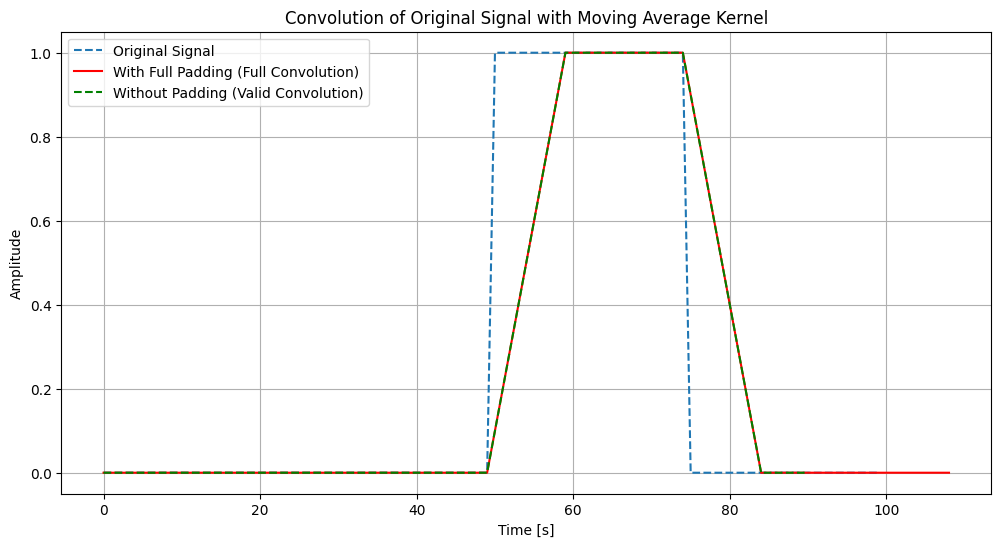

In [4]:
# With Full Padding (Full Convolution)
t0 = time.time()

full_k = np.zeros(len(v) + len(k) - 1)
full_k[:len(k)] = k
full_K = linalg.toeplitz(full_k, np.zeros(len(v)))
full_convolved_signal = full_K @ v

print("Execution time: %1.2e" %(time.time() - t0))

# Without Padding (Valid Convolution)
partial_k = np.zeros(len(v) - len(k) + 1)
partial_k[:len(k)] = k
partial_K = linalg.toeplitz(partial_k, np.zeros(len(v)))
partial_convolved_signal = partial_K @ v

plt.figure(figsize=(12, 6))
plt.plot(v, label="Original Signal", linestyle='--')
plt.plot(full_convolved_signal, label="With Full Padding (Full Convolution)", color="red")
plt.plot(partial_convolved_signal, label="Without Padding (Valid Convolution)", linestyle='--', color='green')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Convolution of Original Signal with Moving Average Kernel')
plt.legend()
plt.grid(True)
plt.show()

## 2. Direct definition (sums of products)

The convolution without "boundary layer" (i.e. the part of the vector which is identical between the standard and the circular convolutions), is given by:

$(\mathbf{k} * \mathbf{v})_i = \sum_{j = 0}^{n_k - 1} \mathbf{k}_{n_k - j} \mathbf{v}_{i + j}$

for $i = 1, \dots, n_v - n_k + 1$.

Execution time: 1.63e+00


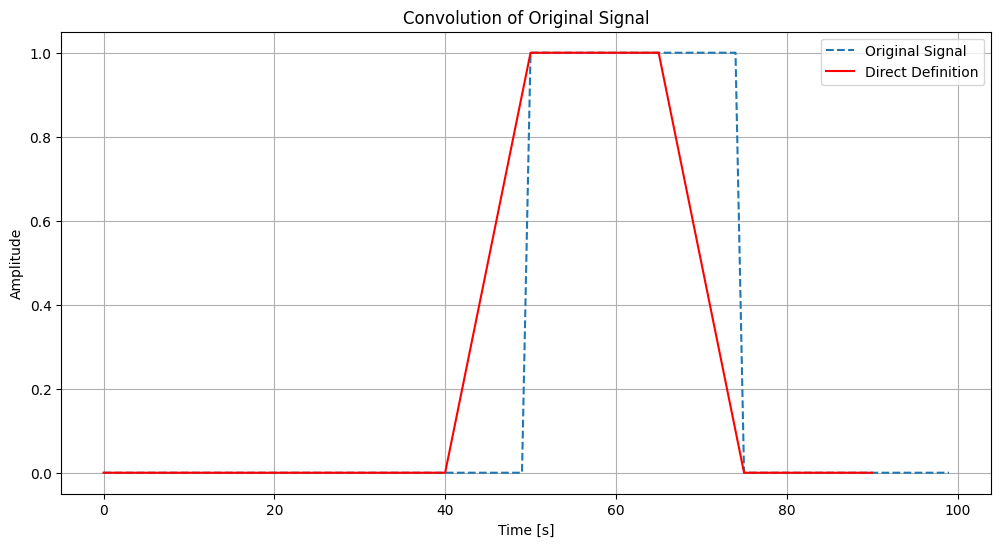

In [5]:
time0 = time.time()

output_length = len(v) - len(k) + 1
v_conv2 = np.zeros(output_length)

for i in range(output_length):
    v_conv2[i] = np.sum(np.flip(k) * v[i : i + len(k)])

print("Execution time: %1.2e" %(time.time() - t0))

# alternative way
# for i in range(output_length):
    # sum_value = 0

    # for j in range(len(k)):
    #     sum_value += k[len(k) - j - 1] * v[i + j]
    # v_conv2[i] = sum_value

plt.figure(figsize=(12, 6))
plt.plot(v, label="Original Signal", linestyle='--')
plt.plot(v_conv2, label="Direct Definition", color="red")
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Convolution of Original Signal')
plt.legend()
plt.grid(True)
plt.show()

## 3. Convolution through DFT

When the two signals have the same size, we have:

$ \widehat{\mathbf{v} \circledast \mathbf{k}} = \widehat{\mathbf{v}} \odot \widehat{\mathbf{k}} $

Where:
- $\hat{\mathbf{a}}$ is the DFT of the signal $\mathbf{a}$
- $\circledast$ is the circular convolution
- $\odot$ is the Hadamard product → element wise product between two matrices

When the two signals do not have the same size, the above formula can be applied simply by "zero-padding" the shorter signal (N.B: this is automatically done by the `numpy.fft.fft` command by passing the required length as second argument).

Besides the filtered signal, plot the DFT of the two signals and of their convolution.


Execution time: 3.11e+00


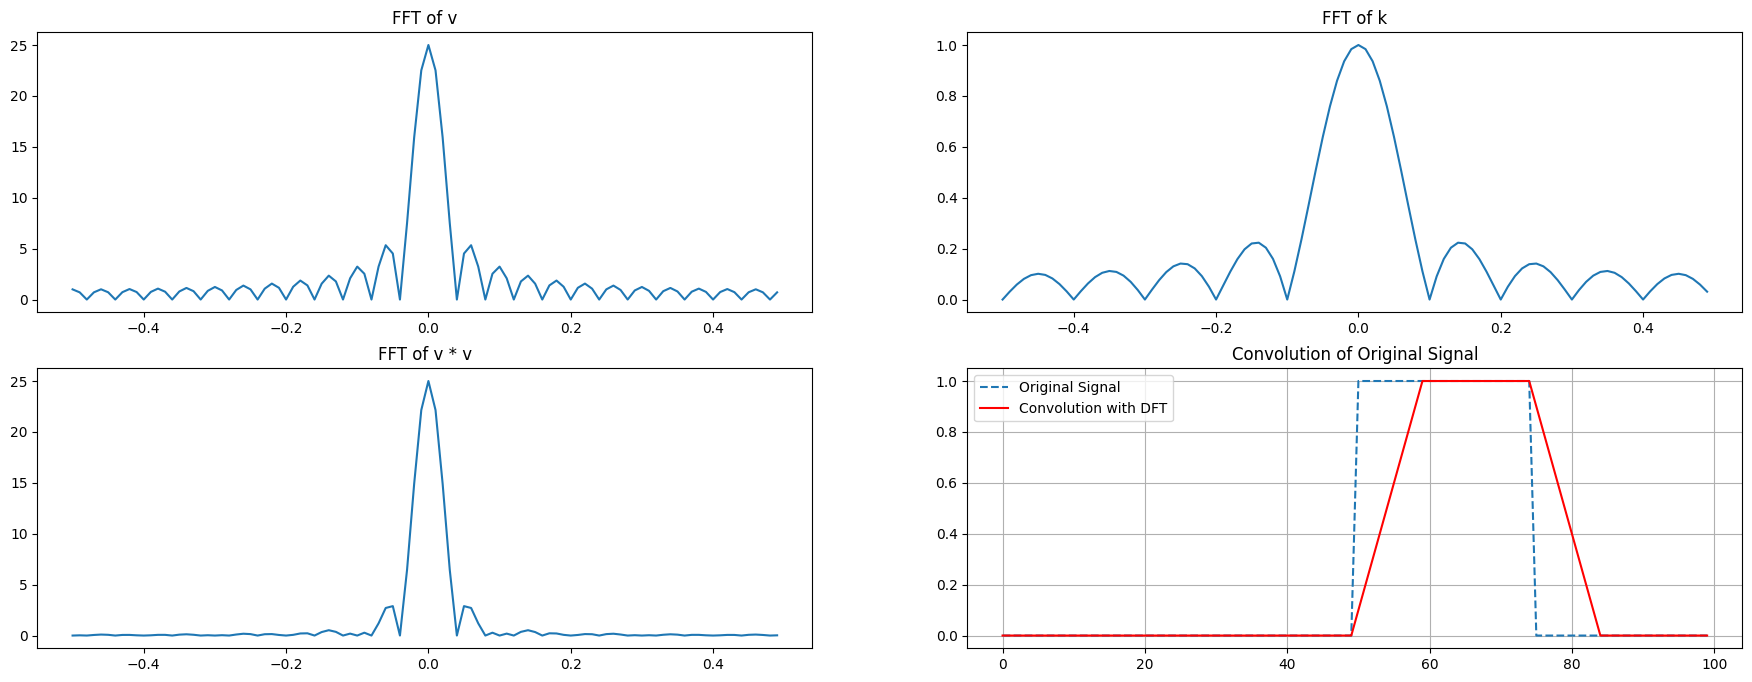

In [6]:
from numpy.fft import fft, ifft, fftshift, fftfreq

time0 = time.time()

v_fft = fft(v)
k_fft = fft(k, len(v))

vk_fft = v_fft * k_fft

v_conv3 = np.real(ifft(vk_fft))

print("Execution time: %1.2e" %(time.time() - t0))

freq = fftfreq(len(v))

fig, axs = plt.subplots(2, 2, figsize=(22, 8))
axs[0, 0].plot(fftshift(freq), fftshift(np.abs(v_fft)))
axs[0, 0].set_title("FFT of v")
axs[0, 1].plot(fftshift(freq), fftshift(np.abs(k_fft)))
axs[0, 1].set_title("FFT of k")
axs[1, 0].plot(fftshift(freq), fftshift(np.abs(vk_fft)))
axs[1, 0].set_title("FFT of v * v")
axs[1, 1].plot(v, label="Original Signal", linestyle='--')
axs[1, 1].plot(v_conv3, label="Convolution with DFT", color="red")
axs[1, 1].set_title("Convolution of Original Signal")
plt.legend()
plt.grid(True)
plt.show()

## 4. Using the command `scipy.signal.convolve`

Check out the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html).

Execution time: 4.18e-04


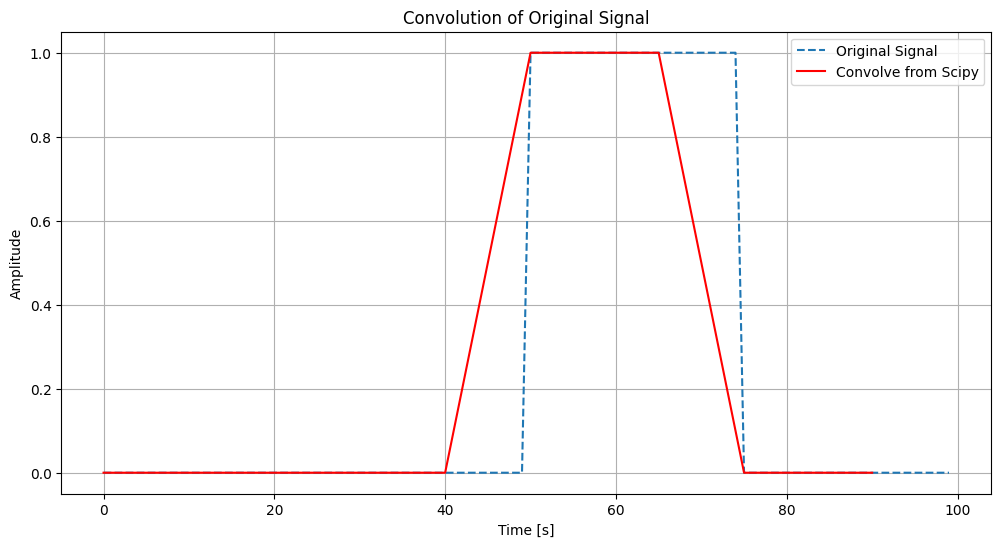

In [7]:
t0 = time.time()

v_conv4 = signal.convolve(v, k, mode="valid")

print("Execution time: %1.2e" %(time.time() - t0))

plt.figure(figsize=(12, 6))
plt.plot(v, label="Original Signal", linestyle='--')
plt.plot(v_conv4, label="Convolve from Scipy", color="red")
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Convolution of Original Signal')
plt.legend()
plt.grid(True)
plt.show()